In [151]:
# Loading the required Pacakges
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.feature_extraction import FeatureHasher
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from scipy import sparse as sp
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, make_scorer
import pickle
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.feature_extraction import FeatureHasher
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 12)

In [3]:
# Load the data 
data = pd.read_csv("./winedata.csv")

In [4]:
data.shape

(129971, 14)

In [5]:
data.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


# EDA

In [284]:
countries=data['country'].value_counts().head(10)
countries=pd.DataFrame({'country':countries.index, 'count':countries.values})
countries.reset_index()
countries.sort_values(by='count',ascending = False)
countries.reset_index()

,index,count,country
0,0,54265,US
1,1,17776,France
2,2,16914,Italy
3,3,6573,Spain
4,4,4875,Portugal
5,5,4416,Chile
6,6,3756,Argentina
7,7,2799,Austria
8,8,2294,Australia
9,9,2120,Germany


# VIZ-1 TOP 10 countries producing wine

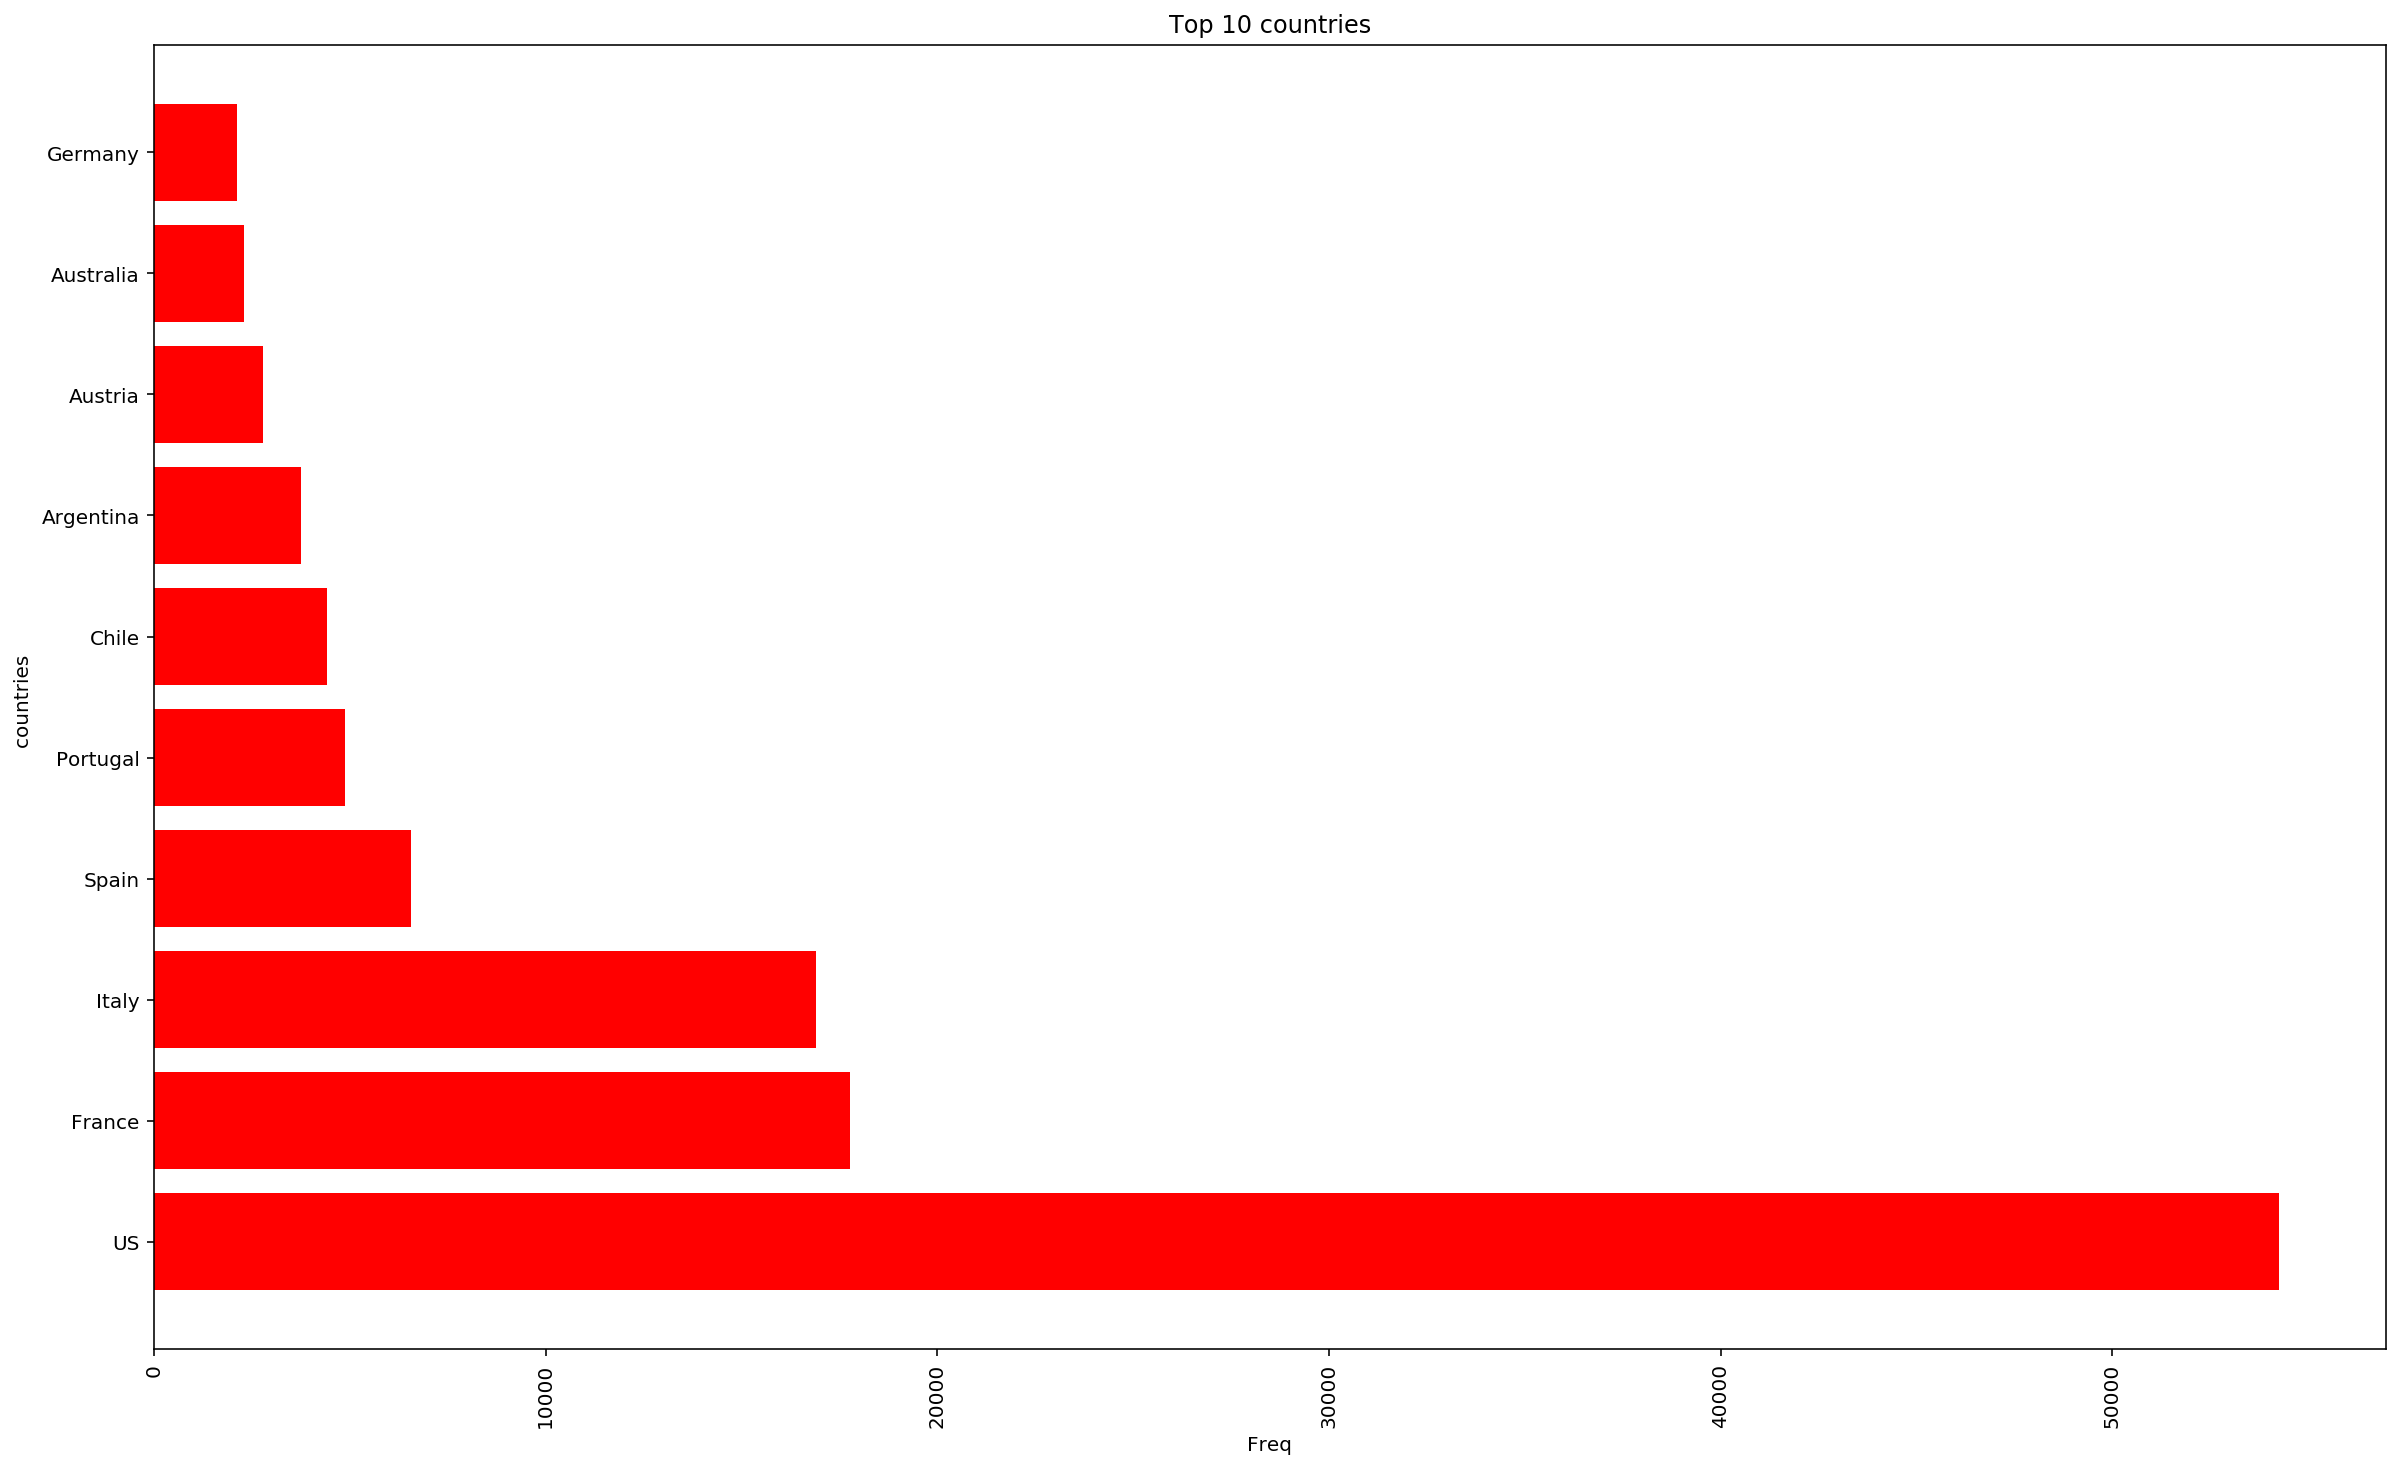

In [285]:
plt.barh(countries['country'],countries['count'],color='red')
plt.xticks(rotation='vertical')
plt.title("Top 10 countries")
plt.ylabel("countries ")
plt.xlabel("Freq")
plt.xticks(rotation=90)
plt.show()

The above plot gives us an overview of the top 10 wine producer countries.
The position is horizontal.
The y-axis represents the top-10 countries
The x-axis represents the number of wines produced by the country.
As we can see from the plot US,FRance, Italy are 3 top most wine producers of the world.
The bar plot is chosen as it suits best to encode the data with one categorical and one numerical attribute.


# Viz-2 DISTRIBUTION of WINE RATINGS

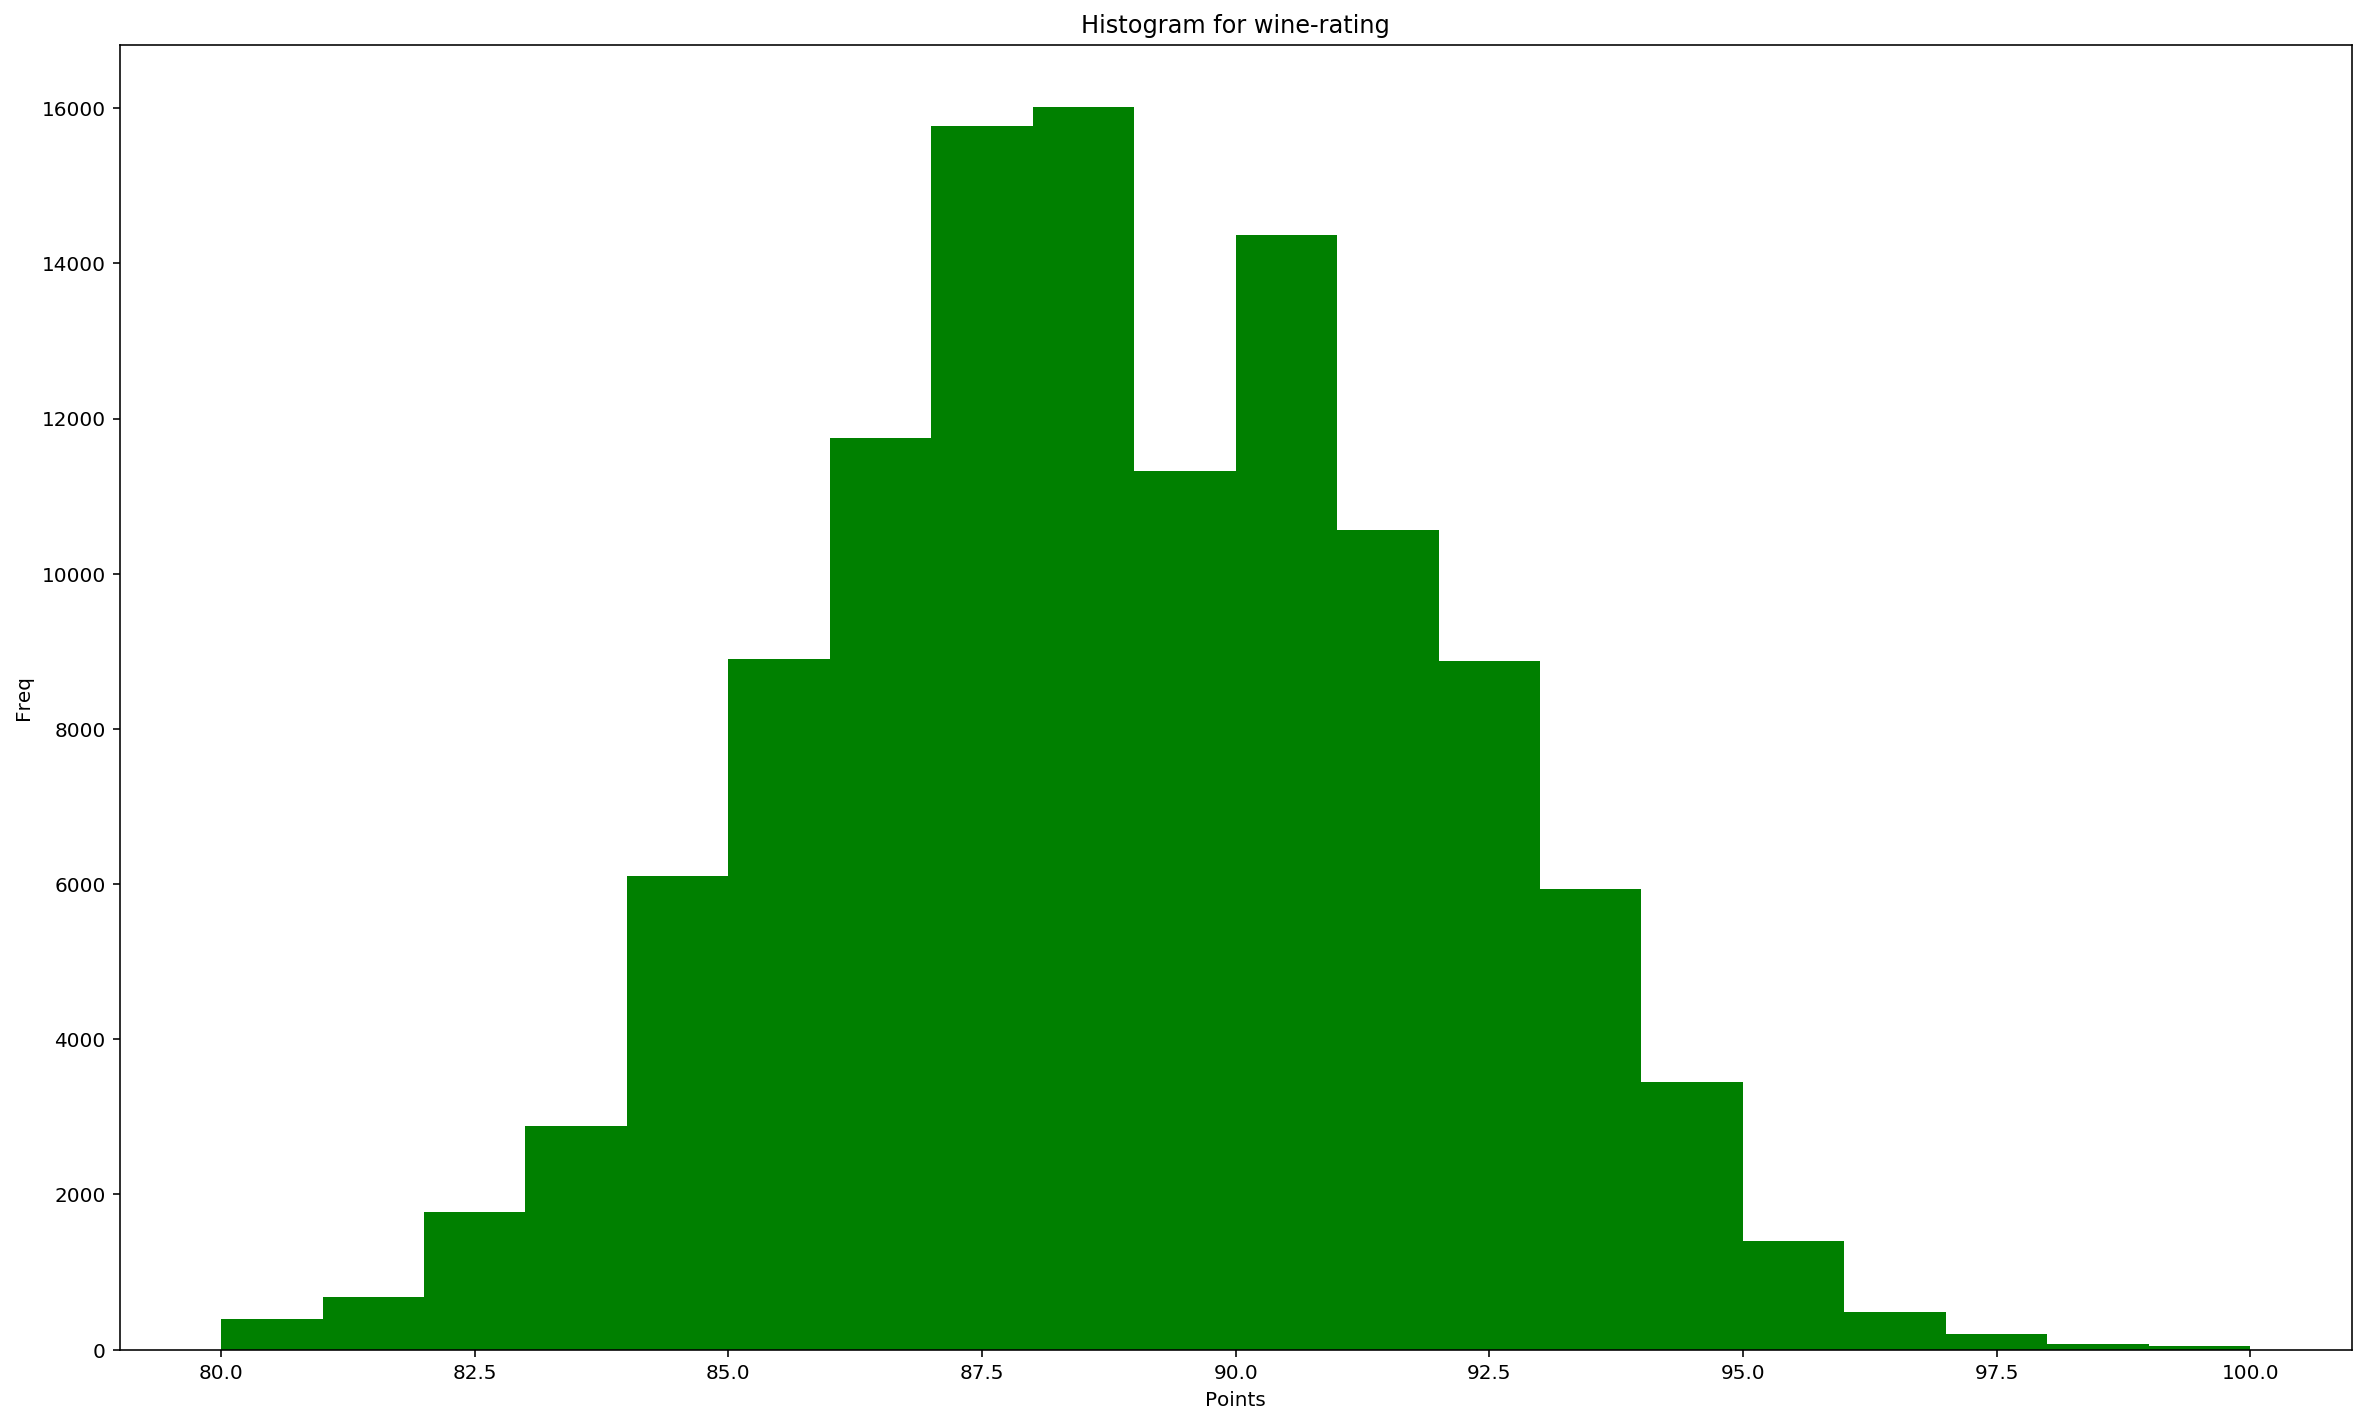

In [275]:

plt.hist(data["points"], bins=20,color='green')
plt.xlabel("Points")
plt.ylabel("Freq")
plt.title("Histogram for wine-rating")
plt.show()

The target variable of the task is to predict the wine ratings given by the tasters.
The above histogram gives us an overview of the distribution of the wine points rating.
As we can see from the plot the range of ratings is from [80,100] and most of the wines are given ratings around 85-90.
The histogram is chosen as the plot as it best suits the distribution of the univariate variable.



# Data Wrangling 

In [10]:
# Delete rows with NAN 
# Dropping the unwanted columns
data=data.drop(columns=['Unnamed: 0','taster_twitter_handle','taster_name','title','designation','region_2'])
data=data.reset_index(drop=True)


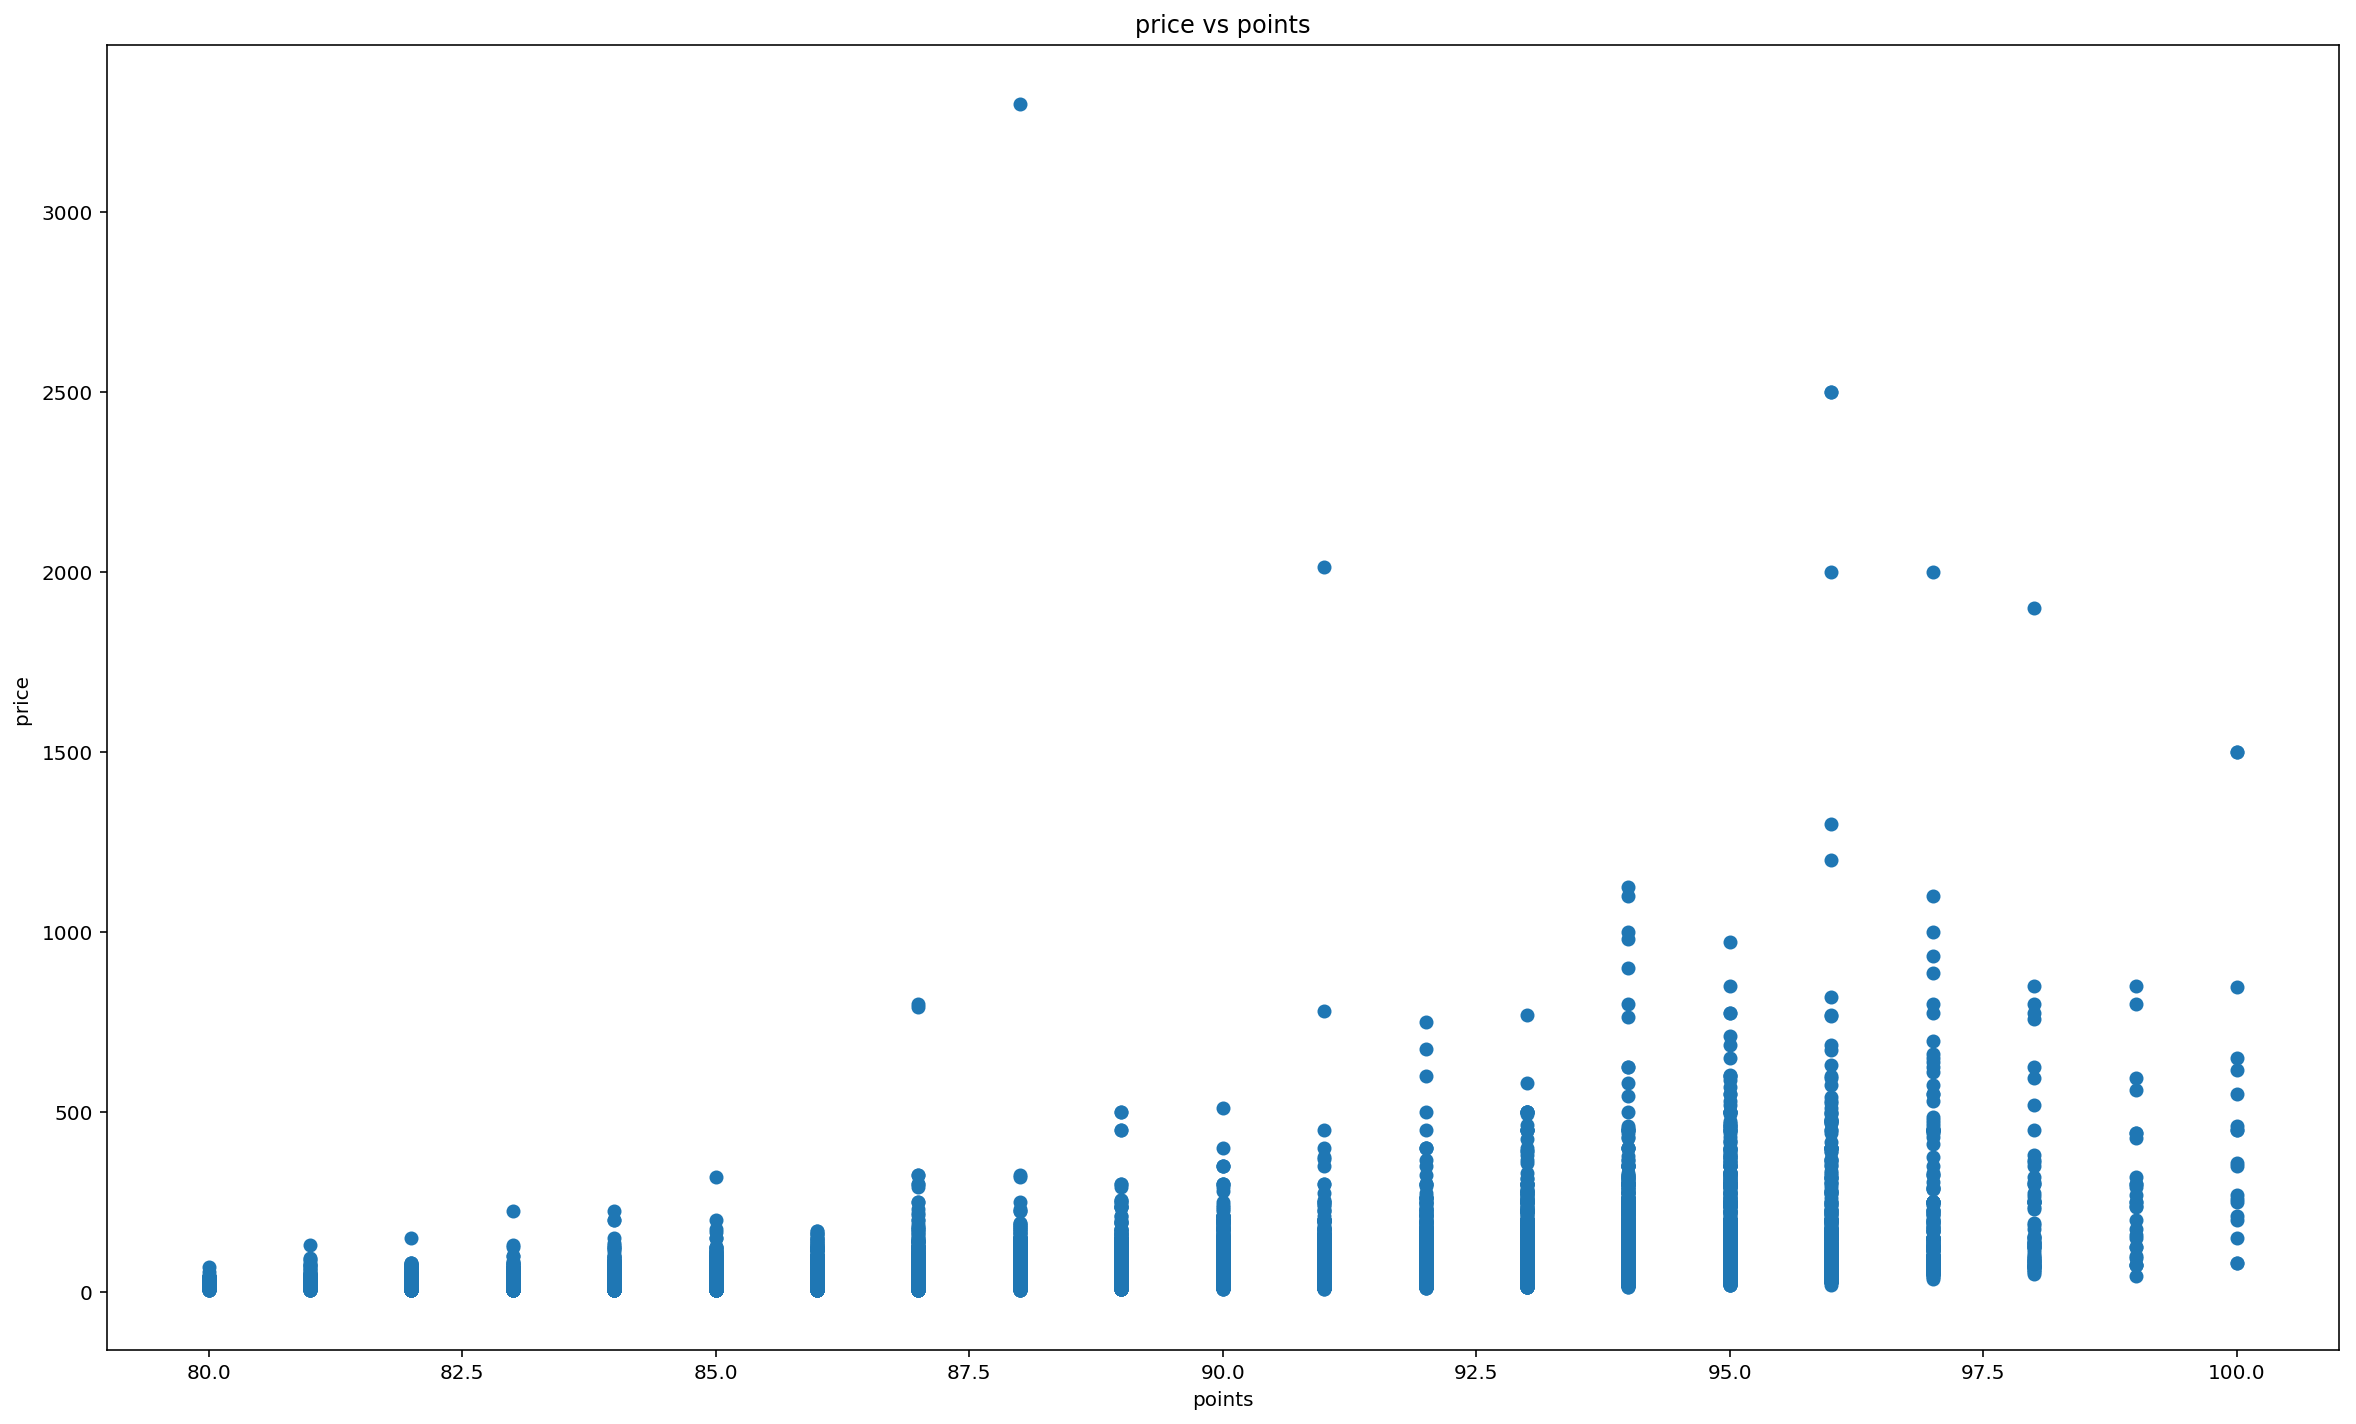

In [287]:
plt.scatter(data['points'],data['price'])
plt.xticks(rotation='horizontal')
plt.title("price vs points")
plt.ylabel("price ")
plt.xlabel("points")
plt.show()


The above plot show how the price of the wine and the wine ratings are correlated.
The scatter plot is chosen as it best suites to determine the collinearity between 2 numerical variables.
As we can see from the plot the best ratings are given for all the costly wines.

The position is horizontal and vertical and channel is point.


In [13]:
total = data.isnull().sum().sort_values(ascending = False)
percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
missing_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
region_1,21247,16.347493
price,8996,6.921544
province,63,0.048472
country,63,0.048472
variety,1,0.000769
winery,0,0.000000
points,0,0.000000
description,0,0.000000


In [14]:
# removing rows which dont have price
data=data.dropna(subset=['price'])
data=data.reset_index(drop=True)

data.fillna('other', inplace=True)

In [17]:
total2 = data.isnull().sum().sort_values(ascending = False)
percent2 = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
missing_data2  = pd.concat([total2, percent2], axis=1, keys=['Total', 'Percent'])
missing_data2

,Total,Percent
winery,0,0.0
variety,0,0.0
region_1,0,0.0
province,0,0.0
price,0,0.0
points,0,0.0
description,0,0.0
country,0,0.0


# Data Cleaning

The rows which containing missing values for the prices are removed.
ALl the NAN from all the columns are filled with others category 


In [19]:
# Split the training data and test data 
X= data.drop(['points'],axis=1)
Y= data['points']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)                                                 

In [20]:
#list of categorical variables 
cat_vars=['country','province','region_1','variety','winery']







# Data Preprocessing 

For the feature processing 
THe data for wine reviews contains 3 different types of variables namely 

1 Numerical variable- ['price'] (Scaled using min-max scaler and is bought into the rang[0,1])


2.Categorical Variables -['country','province','region_1','variety','winery']
The categorical features are encoded using a Hash function with the feature Hasher and each categorical variables levels
are hashed into a vector of size 50.
The original data is very high dimensional when it is one hot encoded and also sparse.
The main reason to choose hasher is that the categorical variables are too wide spread and has too many categories.
and the hashing best represents all the data into a compact vector.
Ref-- https://dzone.com/articles/feature-hashing-for-scalable-machine-learning

    
3.Textual data -['description'] The description column contains tet related to the wine description.
The data is first converted into a count vector using Count vectorizer and then 10 topics 
are extracted from each textual description using the LDA method for both train and test data sets.
So each vector for the description shows its proportion probability of each topic. 





# Feature Hashing for Categorical Variables¶

In [22]:

fh = FeatureHasher(n_features=50, input_type='string')

country_train = pd.DataFrame(fh.fit_transform(X_train['country'].values).toarray())
country_test = pd.DataFrame(fh.transform(X_test['country'].values).toarray())

province_train = pd.DataFrame(fh.fit_transform(X_train['province'].values).toarray())
province_test = pd.DataFrame(fh.transform(X_test['province'].values).toarray())

region_1_train = pd.DataFrame(fh.fit_transform(X_train['region_1'].values).toarray())
region_1_test = pd.DataFrame(fh.transform(X_test['region_1'].values).toarray())

variety_train = pd.DataFrame(fh.fit_transform(X_train['variety'].values).toarray())
variety_test = pd.DataFrame(fh.transform(X_test['variety'].values).toarray())

winery_train = pd.DataFrame(fh.fit_transform(X_train['winery'].values).toarray())
winery_test = pd.DataFrame(fh.transform(X_test['winery'].values).toarray())



In [23]:
X_train_fh=pd.concat([country_train,province_train,region_1_train,variety_train,winery_train],axis= 1)
X_test_fh=pd.concat([country_test,province_test,region_1_test,variety_test,winery_test],axis= 1)

# Scaling the Continous Variables

In [24]:
scaler = MinMaxScaler(feature_range=(0, 1), copy=True)
# Fitting only on training data and testing data 
train_price=pd.DataFrame(scaler.fit_transform(X_train[['price']]),columns=["price"])  
test_price = pd.DataFrame(scaler.transform(X_test[['price']]),columns=["price"]) 

In [25]:
# concat text and numeric data 
X_train_nf=pd.concat([train_price,X_train_fh],axis=1)
X_test_nf=pd.concat([test_price,X_test_fh],axis=1)


# LDA Topic Modelling for Textual Data


In [17]:
no_features = 1000
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=50, max_features=no_features, stop_words='english')
tf = tf_vectorizer.fit_transform(X_train['description'])
lda = LatentDirichletAllocation(n_topics=10, max_iter=5, random_state=0)
dt_matrix = lda.fit_transform(tf)
tf_test=tf_vectorizer.fit_transform(X_test['description'])
test_matix=lda.transform(tf_test)

In [30]:
# Setting the variable names 
lk= ['price']
lf = [i for i in range(1,251)]
for i in lf:
    lk.append(i)
X_train_nf.columns = lk
X_test_nf.columns = lk 
train_desc=pd.DataFrame(dt_matrix,columns=['t1','t2','t3','t4','t5','t6','t7','t8','t9','t10'])
test_desc=pd.DataFrame(test_matix,columns=['t1','t2','t3','t4','t5','t6','t7','t8','t9','t10'])

In [34]:
#combine train, numeric ,categorical and text data 
train_final=pd.concat([X_train_nf,train_desc],axis=1)
test_final=pd.concat([X_test_nf,test_desc],axis=1)

In [ ]:
import pickle
# saving the pickle files of train and test data 
train_final.to_pickle("./train_final.pkl")
test_final.to_pickle("./test_final.pkl")
y_train.to_pickle("./y_train.pkl")
y_test.to_pickle("./y_test.pkl")

# DATA MODELLING

In [ ]:
Since the given task is Regression 3 different ML models are choosen to predict he values of the regression
1. Ridge Regression
2  Gradient-Boosting
3. Bagging Regressor

The optimal parameters for each model choosen  from a given set of defined parameters and is found using  GRid search with a 10 fold cross validation.
The best parameters from the grid search are choosen to predict on the unseen test dataset.

Since it is a Regression Task , the MSE (Mean squared Error) is choosen as an appropriate 
evaluation metric.
All the models are evaluated using MSE on the train and test sets.


# RIDGE REGRESSION


In [277]:
rg = Ridge()
param_grid = {'alpha': [0.06, 0.01,0.05, 0.1,0.2]}
rg_gscv = dcv.GridSearchCV(estimator=rg, param_grid=param_grid, scoring=make_scorer(mean_squared_error), 
                                   cv=10, return_train_score=True,n_jobs=4)

rg_gscv.fit(train_final, y_train)

GridSearchCV(cache_cv=True, cv=10, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       iid=True, n_jobs=4,
       param_grid={'alpha': [0.06, 0.01, 0.05, 0.1, 0.2]}, refit=True,
       return_train_score=True, scheduler=None,
       scoring=make_scorer(mean_squared_error))

In [171]:
# Getting the best parameters from the grid search 
rg_gscv.best_params_

{'alpha': 0.01}

In [172]:
# Best score for training
rg_gscv.best_score_

6.164215131525373

In [173]:
# predicting for the test set based on best params 
rg.best = rg_gscv.best_estimator_
y_pred = rg.best.predict(test_final)
mean_squared_error(y_pred, y_test)

7.133488479650598

In [174]:
# Making the list of cv scores for test data 
rg_res= pd.DataFrame(rg_gscv.cv_results_)
rg_res=rg_res[rg_res["params"] == {'alpha': 0.01}]
rg_cv_score = [ ]
for k in range(10):
        rg_cv_score.append(rg_res["split"+str(k)+"_test_score"].values[0])


# GRADIENT-BOOSTING

In [196]:
param_grid = {'learning_rate': [0.05, 0.07, 0.1],
              'n_estimators': [25,40,50],
              'subsample': [0.5, 0.7, 1.0]}
gb = GradientBoostingRegressor()
gb_gscv = GridSearchCV(estimator=gb, param_grid=param_grid, scoring=make_scorer(mean_squared_error),
                                cv=10, return_train_score=True,n_jobs=5)
gb_gscv.fit(train_final, y_train)

GridSearchCV(cache_cv=True, cv=10, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False),
       iid=True, n_jobs=5,
       param_grid={'learning_rate': [0.05, 0.07, 0.1], 'n_estimators': [25, 40, 50], 'subsample': [0.5, 0.7, 1.0]},
       refit=True, return_train_score=True, scheduler=None,
       scoring=make_scorer(mean_squared_error))

In [197]:
gb_gscv.best_params_

{'learning_rate': 0.05, 'n_estimators': 25, 'subsample': 1.0}

In [198]:
gb_gscv.best_score_

5.990892404942568

In [268]:
# predicting for the test set based on best params 
gb.best = gb_gscv.best_estimator_
y_pred = gb.best.predict(test_final)
mean_squared_error(y_pred, y_test)

5.450630633253695

In [201]:
# Get the list of score from the cv folds
gb_res= pd.DataFrame(gb_gscv.cv_results_)
gb_res=gb_res[gb_res["params"] == {'learning_rate': 0.05, 'n_estimators': 25, 'subsample': 1.0} ]
gb_cv_score = [ ]
for k in range(10):
        gb_cv_score.append(gb_res["split"+str(k)+"_test_score"].values[0])


# BAGGING

In [239]:


param_grid = {'n_estimators': [25, 50],'max_samples': [0.8,1.0]}
             
bg = BaggingRegressor()
bg_gscv = GridSearchCV(estimator=bg, param_grid=param_grid, scoring=make_scorer(mean_squared_error),
                                     cv=10, return_train_score=True,n_jobs=1)
bg_gscv.fit(train_final, y_train)


GridSearchCV(cache_cv=True, cv=10, error_score='raise',
       estimator=BaggingRegressor(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
         verbose=0, warm_start=False),
       iid=True, n_jobs=1,
       param_grid={'n_estimators': [25, 50], 'max_samples': [0.8, 1.0]},
       refit=True, return_train_score=True, scheduler=None,
       scoring=make_scorer(mean_squared_error))

In [240]:
# getting the best score from cv
bg_gscv.best_score_

5.2512191999999995

In [241]:
# getting the best parameters from cv 
bg_gscv.best_params_

{'max_samples': 1.0, 'n_estimators': 25}

In [242]:
# predict the mse for the test data  
bg.best = bg_gscv.best_estimator_
y_pred = bg.best.predict(test_final)
mean_squared_error(y_pred, y_test)

5.494448737342426

In [250]:
# collecting the test score for each fold from cv 
bg_res = pd.DataFrame(bg_gscv.cv_results_)
bg_res=bg_res[bg_res["params"] == { 'n_estimators': 25,'max_samples': 1.0}]
bg_res
bg_cv_score = [ ]
for k in range(10):
       bg_cv_score.append(bg_res["split"+str(k)+"_test_score"].values[0])









# VIZ-3 PLOTTING THE PERFORMANCE OF THE MODELS













In [252]:
data_plot=[rg_cv_score,gb_cv_score,bg_cv_score]

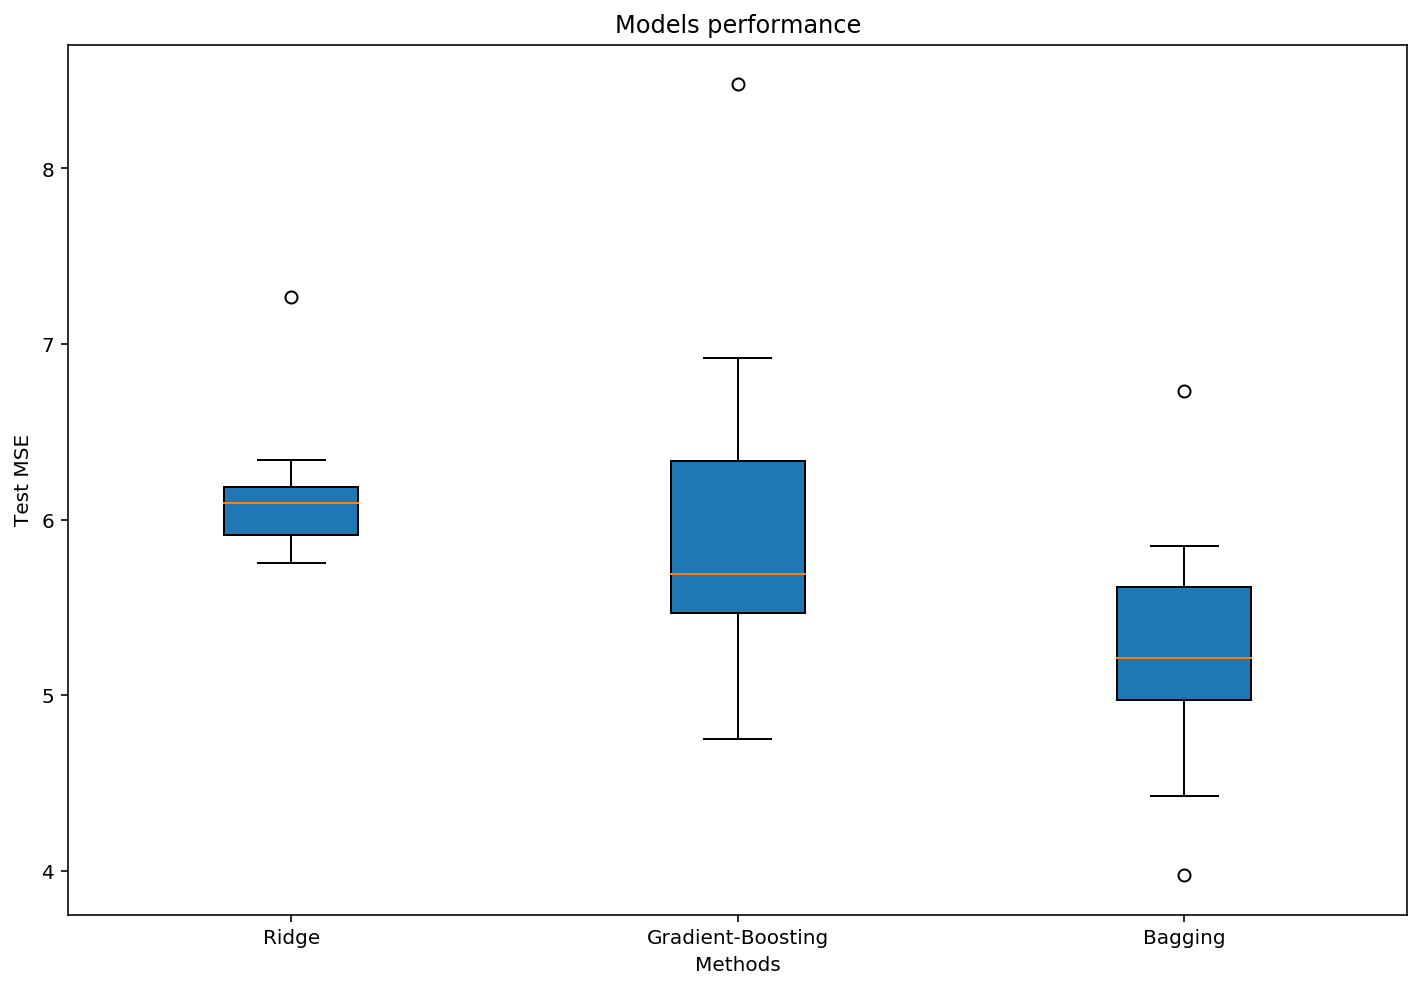

In [288]:

fig = plt.figure(1, figsize=(12, 8))
ax = fig.add_subplot(111)
bp = ax.boxplot(data_plot,patch_artist=True,labels=["Ridge", "Gradient-Boosting", "Bagging"])
plt.xlabel("Methods")
plt.ylabel("Test MSE")
plt.title('Models performance' )
plt.show()


The above plot compares the performance of the 3 machine learning methods fitted on the data set 
The box plot is choosen as it is best to give the summary statistics for a distribution of values. 

The above plot shows the distribution of the  cross validation test scores of each split for each model.
As we can see from the above plot as mean values of the Bagging approach is best compared to the other models.

# VIZ-4 TRAIN/TEST MSE COMPARISION


In [262]:
# we can obtain the train and test mse for the 3 models

ridge=[6.16421513152537,7.133488479650598]
boosting=[5.990895472024961,5.450630633253695]
bagging=[5.2512191999999995,5.494448737342426]
plot_data=[rg,boosting,bagging]

In [271]:
pf=pd.DataFrame(plot_data,columns=['train-mse','test-mse'],index=['ridgeregression','gradientboosting','bagging'])

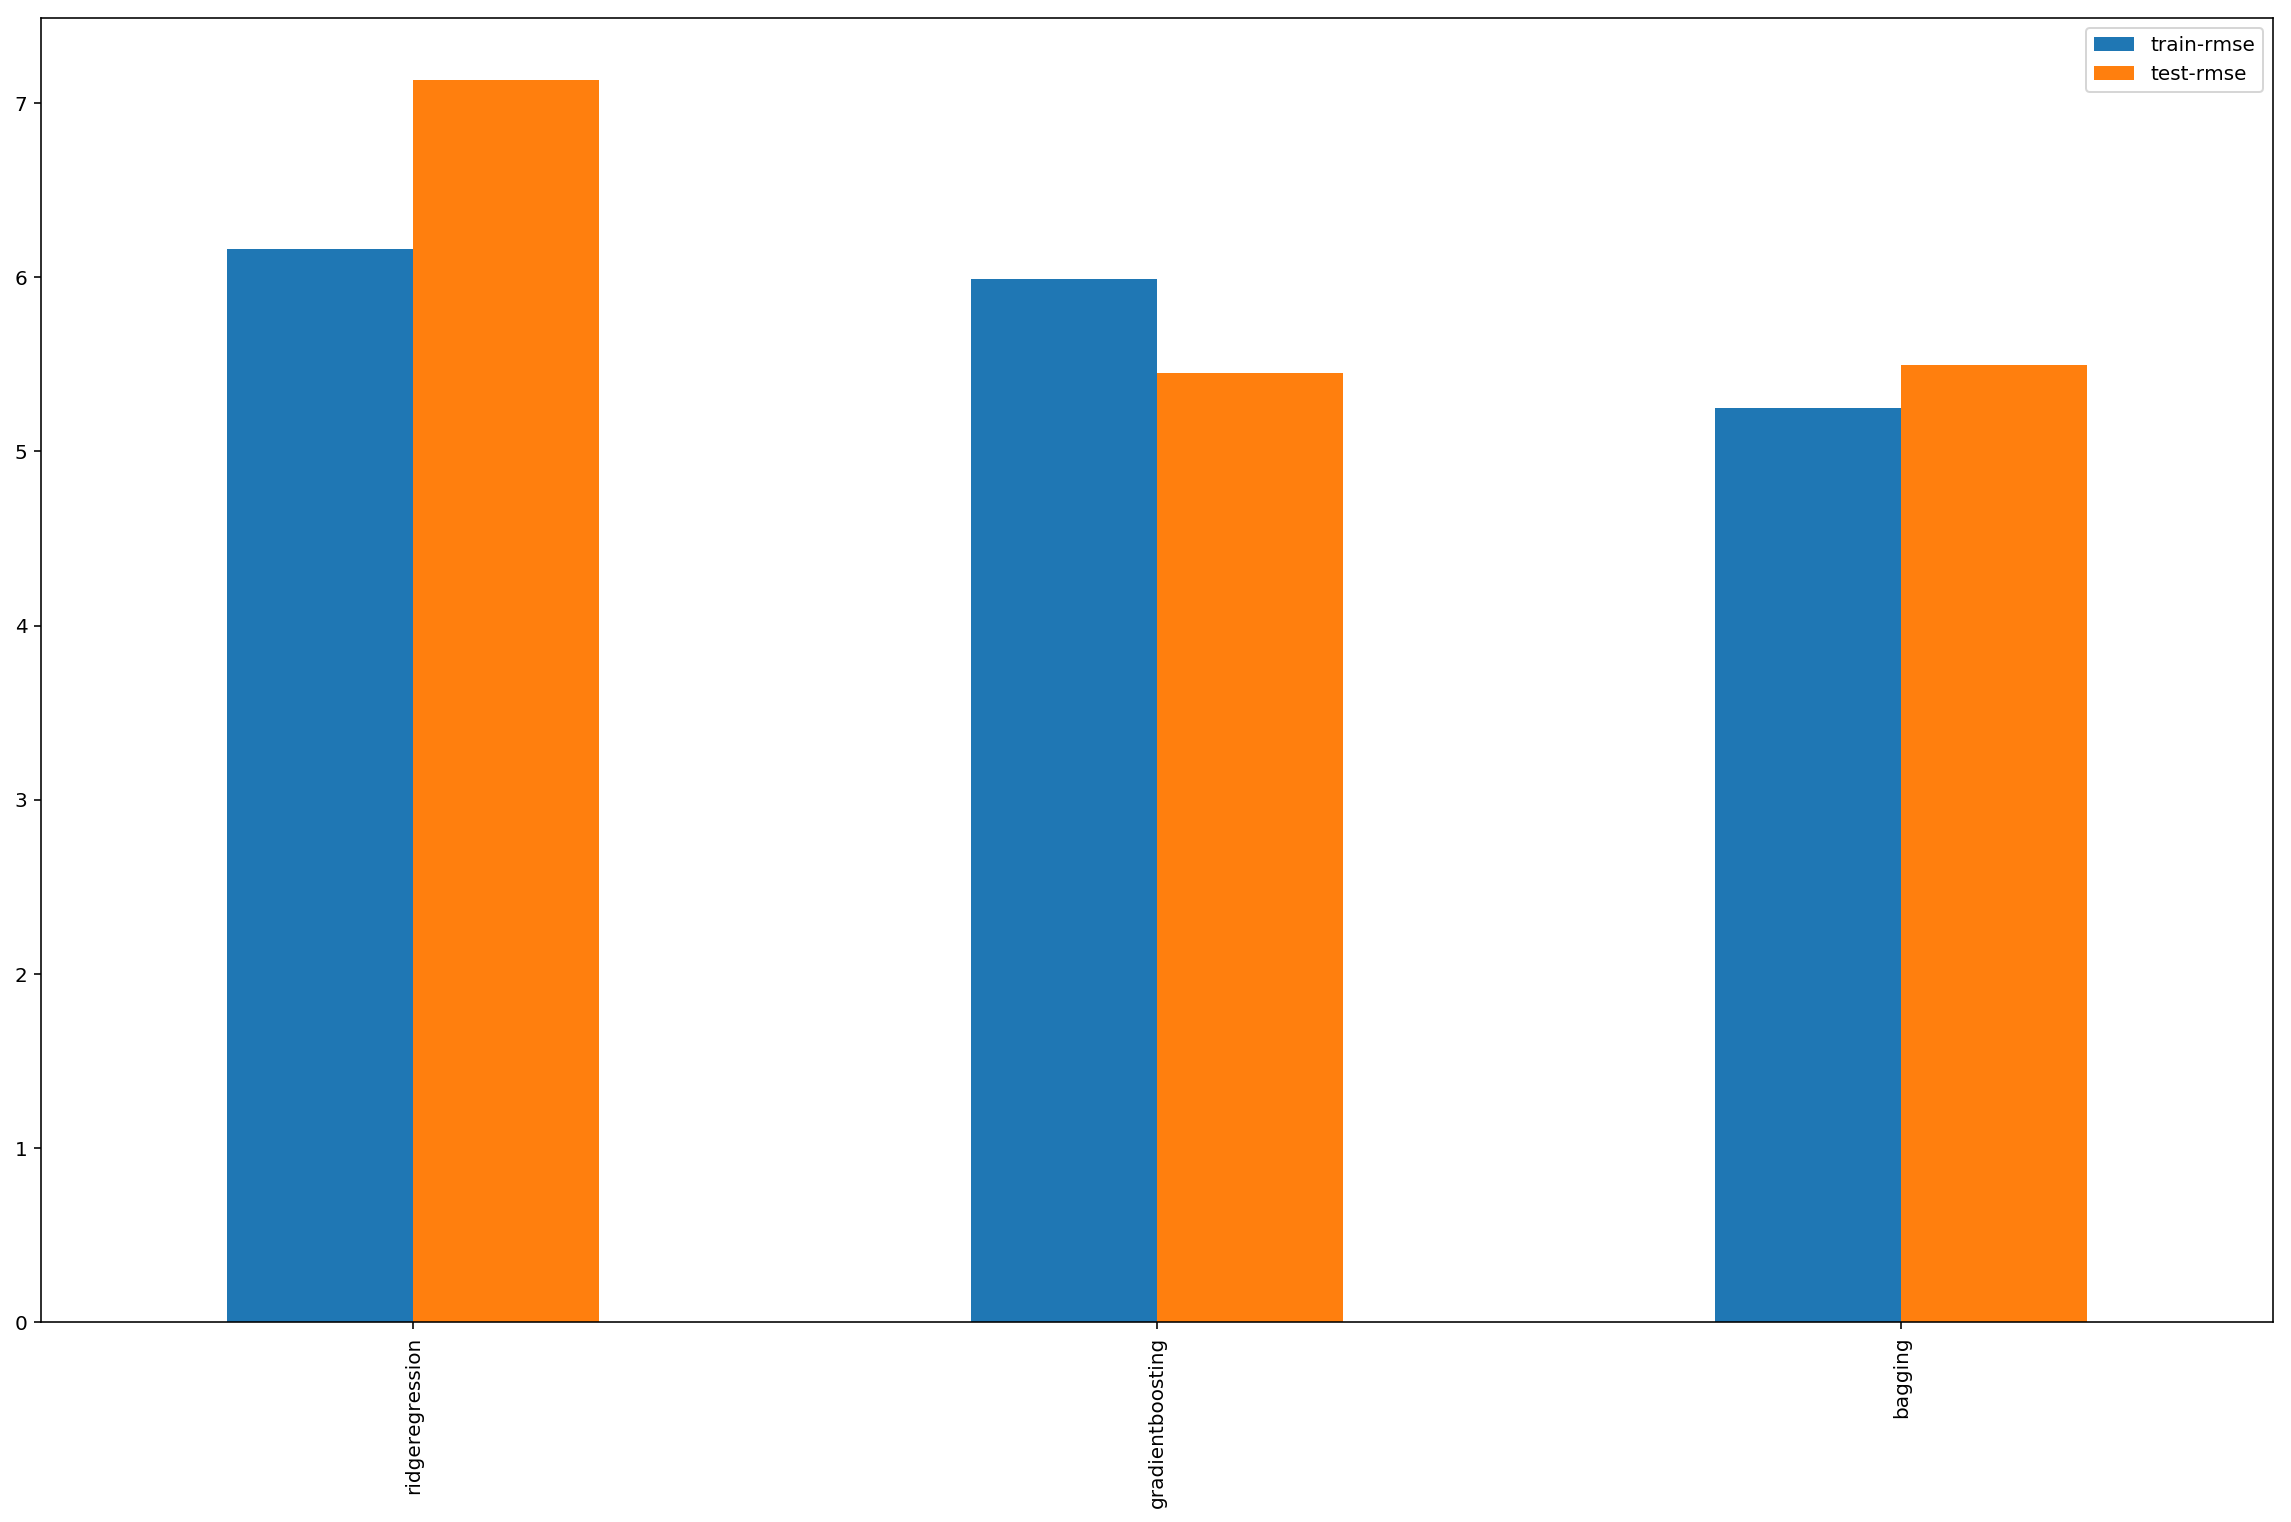

In [272]:
pf.plot(kind='bar')
plt.show()

The above plot compares 3 models with the mse scores for the test and train.
The test score is obtained by using the optimal parameters from the Grid Search method.
The grouped bar chart is choosen as it best to show the variation using the color channel for the train and test mse.

From the above plot we can see that the gradient boosting regressor generalizes the model very well and it has a lowest 
test mse compared to other methods.


the feature importance plot is not choosen as with the use of hash function the original variable names 
cannot be decoded  from the hasher 